In [1]:
%matplotlib inline


Voxel-Based Morphometry on Oasis dataset
========================================

This example uses Voxel-Based Morphometry (VBM) to study the relationship
between aging and gray matter density.

The data come from the `OASIS <http://www.oasis-brains.org/>`_ project.
If you use it, you need to agree with the data usage agreement available
on the website.

It has been run through a standard VBM pipeline (using SPM8 and
NewSegment) to create VBM maps, which we study here.

Predictive modeling analysis: VBM bio-markers of aging?
--------------------------------------------------------

We run a standard SVM-ANOVA nilearn pipeline to predict age from the VBM
data. We use only 100 subjects from the OASIS dataset to limit the memory
usage.

Note that for an actual predictive modeling study of aging, the study
should be ran on the full set of subjects. Also, parameters such as the
smoothing applied to the data and the number of features selected by the
Anova step should be set by nested cross-validation, as they impact
significantly the prediction score.

Brain mapping with mass univariate
-----------------------------------

SVM weights are very noisy, partly because heavy smoothing is detrimental
for the prediction here. A standard analysis using mass-univariate GLM
(here permuted to have exact correction for multiple comparisons) gives a
much clearer view of the important regions.

____




In [2]:
# Authors: Elvis Dhomatob, <elvis.dohmatob@inria.fr>, Apr. 2014
#          Virgile Fritsch, <virgile.fritsch@inria.fr>, Apr 2014
#          Gael Varoquaux, Apr 2014
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker


Load Oasis dataset
-------------------



In [4]:
oasis_dataset = datasets.fetch_oasis_vbm()
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)

# print basic information on the dataset
print('First gray-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.gray_matter_maps[0])  # 3D data
print('First white-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.white_matter_maps[0])  # 3D data

First gray-matter anatomy image (3D) is located at: /home/avell/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: /home/avell/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


/home/avell/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:2258: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Preprocess data
----------------



In [4]:
nifti_masker = NiftiMasker(
    standardize=False,
    smoothing_fwhm=2,
    memory='nilearn_cache')  # cache options
gm_maps_masked = nifti_masker.fit_transform(gray_matter_map_filenames)
n_samples, n_features = gm_maps_masked.shape
print("%d samples, %d features" % (n_subjects, n_features))

100 samples, 902629 features


Prediction pipeline with ANOVA and SVR
---------------------------------------



In [5]:
print("ANOVA + SVR")
# Define the prediction function to be used.
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVR
svr = SVR(kernel='linear')

# Dimension reduction
from sklearn.feature_selection import VarianceThreshold, SelectKBest, \
        f_regression

# Remove features with too low between-subject variance
variance_threshold = VarianceThreshold(threshold=.01)

# Here we use a classical univariate feature selection based on F-test,
# namely Anova.
feature_selection = SelectKBest(f_regression, k=2000)

# We have our predictor (SVR), our feature selection (SelectKBest), and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svr = Pipeline([
            ('variance_threshold', variance_threshold),
            ('anova', feature_selection),
            ('svr', svr)])

### Fit and predict
anova_svr.fit(gm_maps_masked, age)
age_pred = anova_svr.predict(gm_maps_masked)

ANOVA + SVR


Visualization
--------------
Look at the SVR's discriminating weights



/home/avell/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/avell/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


=== ANOVA ===
Prediction accuracy: 0.736385

Massively univariate model


/home/avell/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



1939 detections


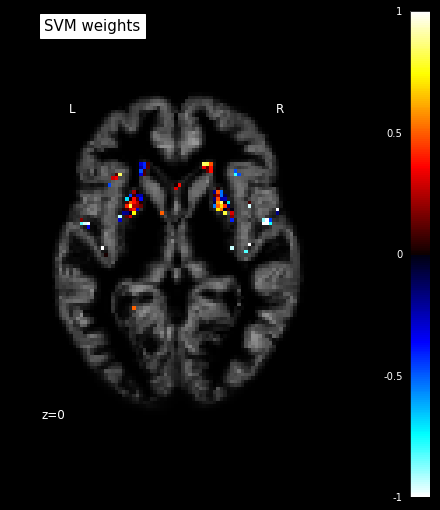

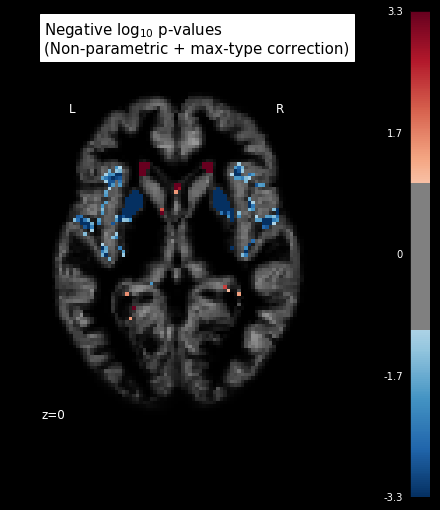

In [6]:
coef = svr.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse variance threshold
coef = variance_threshold.inverse_transform(coef)
# reverse masking
weight_img = nifti_masker.inverse_transform(coef)

# Create the figure
from nilearn.plotting import plot_stat_map, show
bg_filename = gray_matter_map_filenames[0]
z_slice = 0


fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')
# Hard setting vmax to highlight weights more
display = plot_stat_map(weight_img, bg_img=bg_filename,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig, vmax=1)
display.title('SVM weights', y=1.2)

# Measure accuracy with cross validation
from sklearn.cross_validation import cross_val_score
cv_scores = cross_val_score(anova_svr, gm_maps_masked, age)

# Return the corresponding mean prediction accuracy
prediction_accuracy = np.mean(cv_scores)
print("=== ANOVA ===")
print("Prediction accuracy: %f" % prediction_accuracy)
print("")

### Inference with massively univariate model #################################
print("Massively univariate model")

# Statistical inference
from nilearn.mass_univariate import permuted_ols
data = variance_threshold.fit_transform(gm_maps_masked)
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    age, data,  # + intercept as a covariate by default
    n_perm=2000,  # 1,000 in the interest of time; 10000 would be better
    n_jobs=1)  # can be changed to use more CPUs
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    variance_threshold.inverse_transform(signed_neg_log_pvals))

# Show results
threshold = -np.log10(0.1)  # 10% corrected

fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')

display = plot_stat_map(signed_neg_log_pvals_unmasked, bg_img=bg_filename,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig)
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)')
display.title(title, y=1.2)

n_detections = (signed_neg_log_pvals_unmasked.get_data() > threshold).sum()
print('\n%d detections' % n_detections)

show()

In [6]:
import os
from nibabel.testing import data_path
import nibabel as nib
from scipy.misc import imsave
from skimage import img_as_ubyte
import bisect

def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    dst = src.copy()
    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=np.int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - vin[0], 0)
            vd = min(int(vs * scale + 0.5) + vout[0], vout[1])
            dst[r,c] = vd
    return dst

set_range = lambda src : (src-np.min(src[:]))/(np.max(src[:])-np.min(src[:]))

for i in range(len(oasis_dataset.gray_matter_maps)):
    file = oasis_dataset.gray_matter_maps[i]
    file_name = file.split('/')[5]
    example_filename = os.path.join(data_path, '/home/avell/ADNI.nii')

    img = nib.load(example_filename)
    data = img.get_data()

    R,L = data[:,:,0].shape
    
    axial = data[:,:,R//2]
    coronal = np.rot90(data[:,L//2,:])
  
    axial = imadjust(img_as_ubyte(set_range(axial)))
    coronal = imadjust(img_as_ubyte(set_range(coronal)))
    
    imsave(file_name+'_a.jpg',axial)
    imsave(file_name+'_c.jpg',coronal)
    
    break;

/home/avell/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/avell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/avell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


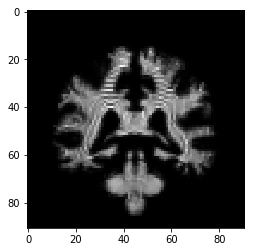